
####  Importing required packages

In [114]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split as split

from keras.layers import LSTM, Input, Dense
from keras.models import Model

from deap import base, creator, tools, algorithms
from scipy.stats import bernoulli
from bitstring import BitArray

from pandas import read_csv
from datetime import datetime

from pandas import DataFrame
from pandas import concat

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from numpy import concatenate

np.random.seed(1120)

#### Basic Data Preparation

The first step is to consolidate the date-time information into a single date-time so that we can use it as an index in Pandas.
  

In [118]:
# load data
# def parse(x):
#    return datetime.strptime(x, '%b-%d-%Y')
dataset = read_csv('data/raw.csv', index_col=3)


# manually specify column names
dataset.columns = ['statename','activity_level','activity_level_label','season','weeknumber','Latitude','Longitude']
dataset.index.name = 'date'


# convert index to datetime
dataset.index = pd.to_datetime(dataset.index, format='%b-%d-%Y')

# clean the dataset
dataset.drop(['statename', 'season', 'weeknumber'], axis=1, inplace=True)

# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('data.csv')

            activity_level activity_level_label   Latitude  Longitude
date                                                                 
2016-10-01               1              Minimal  32.806671  -86.79113
2016-09-24               1              Minimal  32.806671  -86.79113
2016-09-17               1              Minimal  32.806671  -86.79113
2016-09-10               1              Minimal  32.806671  -86.79113
2016-09-03               1              Minimal  32.806671  -86.79113


Now that we have the data in an easy-to-use form, we can create a quick plot of each series and see what we have.

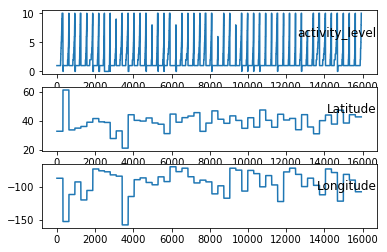

In [119]:

# load dataset
dataset = read_csv('data.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0,2,3]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

## Multivariate LSTM Forecast Model

In this section, we will fit an LSTM to the problem.

LSTM Data Preparation

The first step is to prepare the ILI dataset for the LSTM.

This involves framing the dataset as a supervised learning problem and normalizing the input variables.

We will frame the supervised learning problem as predicting the pollution for the current week (t) given the pollution measurement and weather conditions at the prior time step.

This formulation is straightforward and just for this demonstration. Some alternate formulations you could explore include:

### Todo
-  Predict the ILI activity for the next week based on the location  over the last 6 months.
-  Predict the ILI activity for the next week as above and given the “expected” location for the next week.

Next, all features are normalized, then the dataset is transformed into a supervised learning problem. The ILI variables for the week to be predicted (t) are then removed.

### Reading dataset + Split and Train

In [111]:
# split into train and test sets
values = reframed.values
n_train_hours = int(len(values) * 0.7)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

####  Defining Helper Functions

In [112]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


def prepare_dataset(data, window_size):
    X, Y = np.empty((0,window_size)), np.empty((0))
    for i in range(len(data)-window_size-1):
        X = np.vstack([X,data[i:(i + window_size),0]])
        Y = np.append(Y,data[i + window_size,0])   
    X = np.reshape(X,(len(X),window_size,1))
    Y = np.reshape(Y,(len(Y),1))
    return X, Y

def train_evaluate(ga_individual_solution):   
    # Decode GA solution to integer for window_size and num_units
    window_size_bits = BitArray(ga_individual_solution[0:6])
    num_units_bits = BitArray(ga_individual_solution[6:]) 
    window_size = window_size_bits.uint
    num_units = num_units_bits.uint
    print('\nWindow Size: ', window_size, ', Num of Units: ', num_units)
    
    # ensure all data is float
    values = values.astype('float32')
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    # frame as supervised learning
    reframed = series_to_supervised(scaled, 1, 1)
    
    
    
    # Return fitness score of 100 if window_size or num_unit is zero
    if window_size == 0 or num_units == 0:
        return 100, 
    
    # Segment the train_data based on new window_size; split into train and validation (80/20)
    X,Y = prepare_dataset(train_data,window_size)
    X_train, X_val, y_train, y_val = split(X, Y, test_size = 0.20, random_state = 1120)
    
    # Train LSTM model and predict on validation set
    inputs = Input(shape=(window_size,1))
    x = LSTM(num_units, input_shape=(window_size,1))(inputs)
    predictions = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(optimizer='adam',loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=5, batch_size=10,shuffle=True)
    y_pred = model.predict(X_val)
    
    # Calculate the RMSE score as fitness score for GA
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    print('Validation RMSE: ', rmse,'\n')
    
    return rmse,

In [113]:
# load dataset
dataset = read_csv('data.csv', header=0, index_col=0)
values = dataset.values

# integer encode activity level (I am testing if it works)
encoder = LabelEncoder()
values[:,1] = encoder.fit_transform(values[:,1])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)


# drop columns we don't want to predict
#reframed.drop(reframed.columns[[2,3,4,5]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var1(t)  var2(t)   var3(t)  \
1        0.1       0.75   0.290799   0.802429      0.1     0.75  0.290799   
2        0.1       0.75   0.290799   0.802429      0.1     0.75  0.290799   
3        0.1       0.75   0.290799   0.802429      0.1     0.75  0.290799   
4        0.1       0.75   0.290799   0.802429      0.1     0.75  0.290799   
5        0.1       0.75   0.290799   0.802429      0.1     0.75  0.290799   

    var4(t)  
1  0.802429  
2  0.802429  
3  0.802429  
4  0.802429  
5  0.802429  


## Define and Fit Model

In this section, we will fit an LSTM on the multivariate input data.

First, we must split the prepared dataset into train and test sets. To speed up the training of the model for this demonstration, we will only fit the model on the first year of data, then evaluate it on the remaining 4 years of data. If you have time, consider exploring the inverted version of this test harness.

The example below splits the dataset into train and test sets, then splits the train and test sets into input and output variables. Finally, the inputs (X) are reshaped into the 3D format expected by LSTMs, namely [samples, timesteps, features].

In [ ]:


# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

## Design the network

Now we can define and fit our LSTM model.

We will define the LSTM with 50 neurons in the first hidden layer and 1 neuron in the output layer for predicting pollution. The input shape will be 1 time step with 4 features.

We will use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.

The model will be fit for 50 training epochs with a batch size of 72. Remember that the internal state of the LSTM in Keras is reset at the end of each batch, so an internal state that is a function of a number of days may be helpful (try testing this).

Finally, we keep track of both the training and test loss during training by setting the validation_data argument in the fit() function. At the end of the run both the training and test loss are plotted.

Train on 48 samples, validate on 15884 samples
Epoch 1/50
0s - loss: 0.7455 - val_loss: 0.6541
Epoch 2/50
0s - loss: 0.7333 - val_loss: 0.6421
Epoch 3/50
0s - loss: 0.7212 - val_loss: 0.6301
Epoch 4/50
0s - loss: 0.7090 - val_loss: 0.6181
Epoch 5/50
0s - loss: 0.6968 - val_loss: 0.6061
Epoch 6/50
0s - loss: 0.6846 - val_loss: 0.5940
Epoch 7/50
0s - loss: 0.6724 - val_loss: 0.5820
Epoch 8/50
0s - loss: 0.6601 - val_loss: 0.5698
Epoch 9/50
0s - loss: 0.6479 - val_loss: 0.5577
Epoch 10/50
0s - loss: 0.6356 - val_loss: 0.5454
Epoch 11/50
0s - loss: 0.6232 - val_loss: 0.5331
Epoch 12/50
0s - loss: 0.6108 - val_loss: 0.5207
Epoch 13/50
0s - loss: 0.5983 - val_loss: 0.5083
Epoch 14/50
0s - loss: 0.5857 - val_loss: 0.4957
Epoch 15/50
0s - loss: 0.5731 - val_loss: 0.4831
Epoch 16/50
0s - loss: 0.5603 - val_loss: 0.4703
Epoch 17/50
0s - loss: 0.5475 - val_loss: 0.4574
Epoch 18/50
0s - loss: 0.5345 - val_loss: 0.4444
Epoch 19/50
0s - loss: 0.5215 - val_loss: 0.4313
Epoch 20/50
0s - loss: 0.5083 -

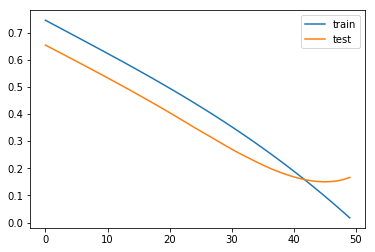

error 0
error 1


ValueError: operands could not be broadcast together with shapes (15884,7) (4,) (15884,7) 

In [99]:


# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


print("error 0")

#make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

print("error 1")

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

print("error 2")

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

print("error 3")

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

### Evaluate Model